In [13]:
import yfinance as yf
import pandas as pd

# Define the stock tickers
tickers = ["AAPL", "META", "TSLA"]

# Fetch historical adjusted closing prices
data = yf.download(tickers, start="2018-01-01", end="2023-01-01")['Adj Close']

# Save the raw data to a CSV file
data.to_csv("stock_prices_all.csv")

# Check for missing values
print("Missing values before handling:")
print(data.isnull().sum())

# Handle missing values (forward-fill and back-fill)
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Confirm no missing values remain
print("Missing values after handling:")
print(data.isnull().sum())

# Save the cleaned data to a CSV file
data.to_csv("stock_prices_cleaned.csv")

print("Data successfully saved to stock_prices_cleaned.csv")


[*********************100%***********************]  3 of 3 completed

Missing values before handling:
Ticker
AAPL    0
META    0
TSLA    0
dtype: int64
Missing values after handling:
Ticker
AAPL    0
META    0
TSLA    0
dtype: int64
Data successfully saved to stock_prices_cleaned.csv



/var/folders/_t/j4c3wrb10pl92g2bqgdqtl200000gn/T/ipykernel_19692/1270361498.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
/var/folders/_t/j4c3wrb10pl92g2bqgdqtl200000gn/T/ipykernel_19692/1270361498.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)


              AAPL         META         TSLA
count  1259.000000  1259.000000  1259.000000
mean     95.808114   217.236531   131.784972
std      46.189873    66.713069   117.835854
min      33.952545    88.643105    11.931333
25%      48.993065   170.018105    21.078333
50%      89.287987   193.886230    80.577332
75%     140.687607   266.063919   236.125000
max     179.076569   381.032745   409.970001


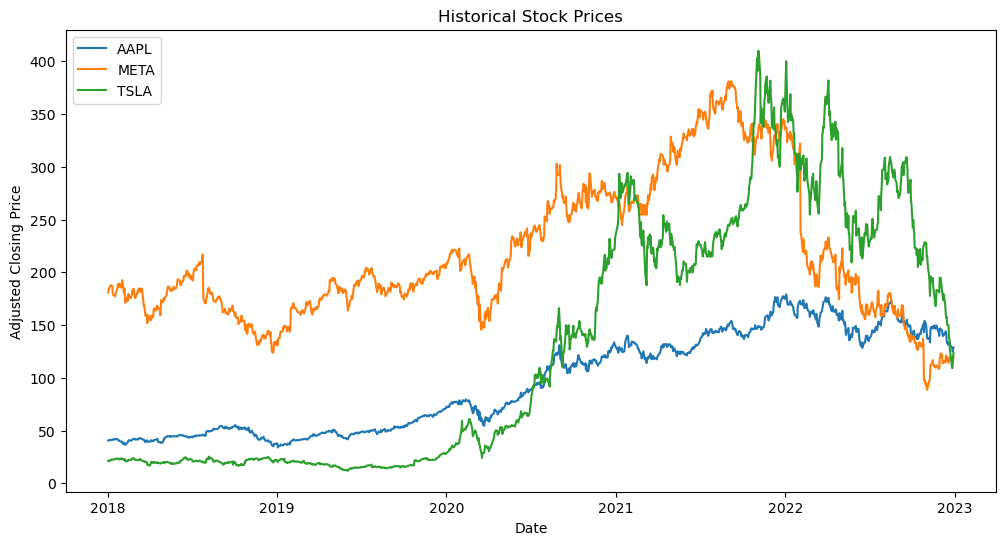

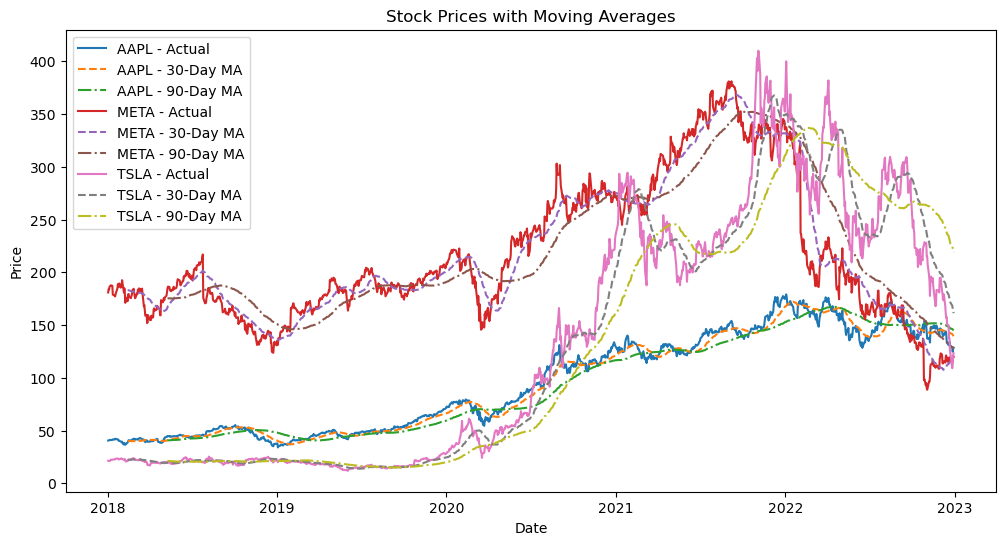

          AAPL      META      TSLA
AAPL  1.000000  0.510086  0.961331
META  0.510086  1.000000  0.540435
TSLA  0.961331  0.540435  1.000000


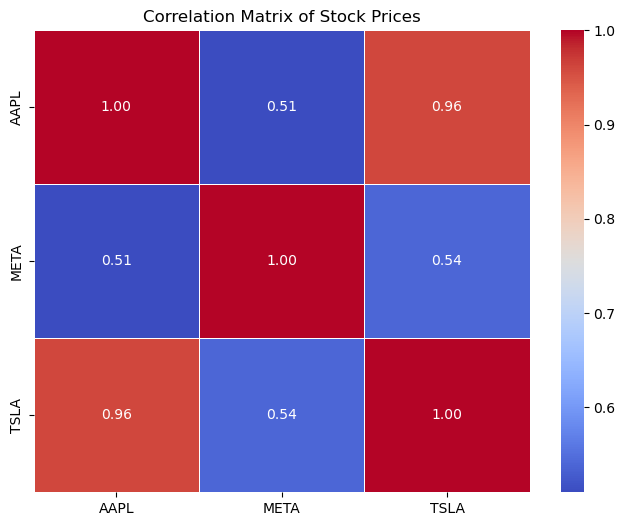

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
data = pd.read_csv("stock_prices_cleaned.csv", index_col=0, parse_dates=True)

# Generate summary statistics
summary_stats = data.describe()
print(summary_stats)

# Save summary statistics to CSV
summary_stats.to_csv("stock_summary_statistics.csv")

# Plot historical stock prices
plt.figure(figsize=(12, 6))
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)
plt.title("Historical Stock Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.legend(loc="upper left")
plt.savefig("historical_stock_prices.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate moving averages
moving_avg_30 = data.rolling(window=30).mean()
moving_avg_90 = data.rolling(window=90).mean()

# Plot moving averages
plt.figure(figsize=(12, 6))
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=f"{ticker} - Actual")
    plt.plot(moving_avg_30.index, moving_avg_30[ticker], linestyle='--', label=f"{ticker} - 30-Day MA")
    plt.plot(moving_avg_90.index, moving_avg_90[ticker], linestyle='-.', label=f"{ticker} - 90-Day MA")
plt.title("Stock Prices with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.savefig("stock_prices_moving_averages.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

# Save correlation matrix to CSV
correlation_matrix.to_csv("stock_correlation_matrix.csv")

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Stock Prices")
plt.savefig("correlation_matrix_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

[*********************100%***********************]  3 of 3 completed
17:25:36 - cmdstanpy - INFO - Chain [1] start processing
17:25:36 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: AAPL


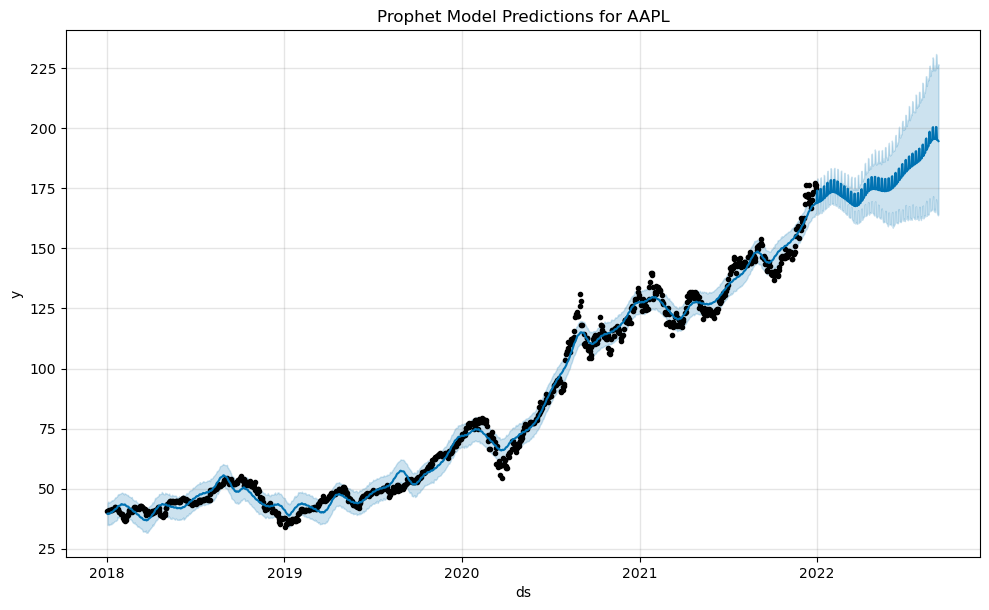

17:25:36 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: TSLA


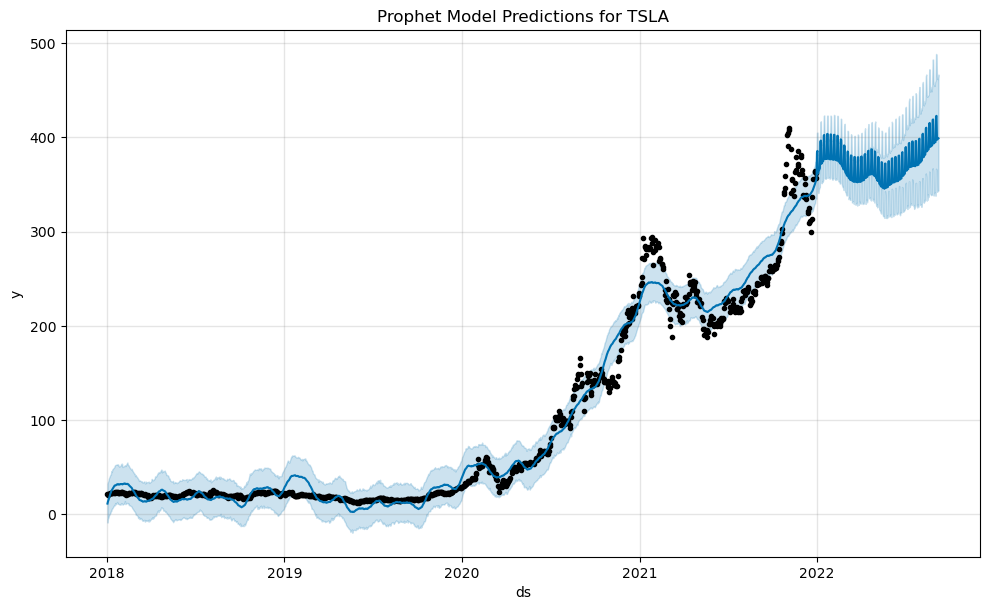

17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: META


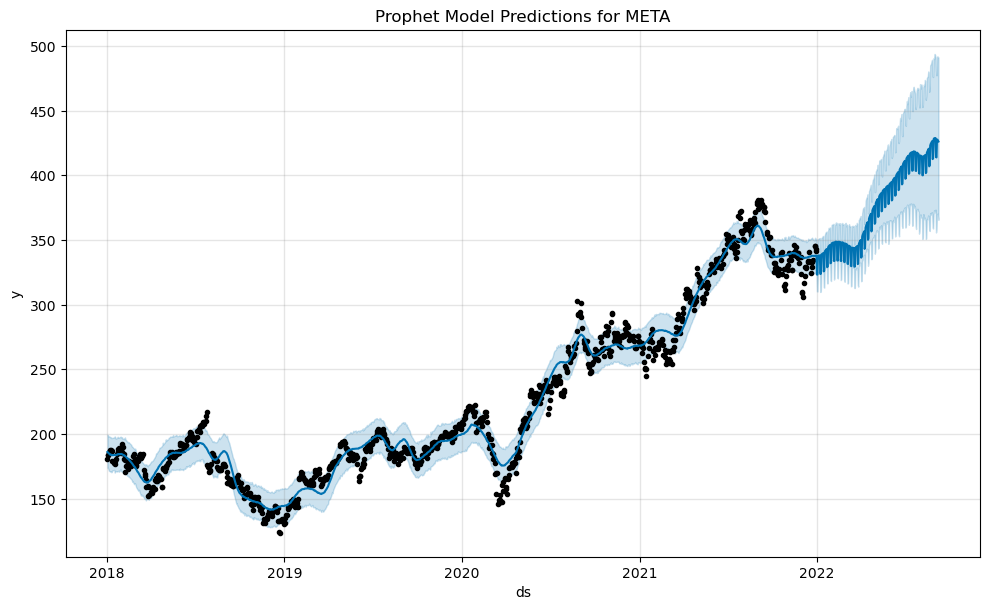

In [17]:
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt  # Ensure this is imported for plotting

tickers = ["AAPL", "TSLA", "META"]
stock_data = yf.download(tickers, start="2018-01-01", end="2023-01-01")["Adj Close"]

# Iterate through each stock for analysis
for stock in tickers:
    print(f"Processing stock: {stock}")
    
    # Select the stock data
    stock_series = stock_data[stock]
    
    # Train-Test Split (80-20)
    train_size = int(len(stock_series) * 0.8)
    train, test = stock_series[:train_size], stock_series[train_size:]

    # Prepare the training data for Prophet
    train_df = train.reset_index()
    train_df.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for values
    train_df['ds'] = train_df['ds'].dt.tz_localize(None)  # Remove timezone information if present

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Plot the forecast
    model.plot(forecast)
    plt.title(f"Prophet Model Predictions for {stock}")
    plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dictionary to store evaluation results
evaluation_results = {}

# Iterate through each stock for evaluation
for stock in tickers:
    print(f"Evaluating stock: {stock}")
    
    # Select the stock data
    stock_series = stock_data[stock]
    
    # Train-Test Split (80-20)
    train_size = int(len(stock_series) * 0.8)
    train, test = stock_series[:train_size], stock_series[train_size:]

    # Prepare the training data for Prophet
    train_df = train.reset_index()
    train_df.columns = ['ds', 'y']
    train_df['ds'] = train_df['ds'].dt.tz_localize(None)

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Align forecast with the test data
    forecast_test = forecast.tail(len(test))
    forecast_test = forecast_test.reset_index(drop=True)
    test = test.reset_index(drop=True)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test, forecast_test['yhat'])
    rmse = np.sqrt(mean_squared_error(test, forecast_test['yhat']))
    evaluation_results[stock] = {'MAE': mae, 'RMSE': rmse}

    print(f"{stock} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Save the evaluation results 
evaluation_df = pd.DataFrame(evaluation_results).T  # Transpose for better readability
evaluation_df.to_csv("forecast_evaluation_metrics.csv")
print("Evaluation metrics saved to forecast_evaluation_metrics.csv")

# Display the evaluation metrics
print(evaluation_df)

17:25:42 - cmdstanpy - INFO - Chain [1] start processing
17:25:42 - cmdstanpy - INFO - Chain [1] done processing


Evaluating stock: AAPL


17:25:42 - cmdstanpy - INFO - Chain [1] start processing
17:25:42 - cmdstanpy - INFO - Chain [1] done processing


AAPL - MAE: 26.10, RMSE: 31.86
Evaluating stock: TSLA


17:25:42 - cmdstanpy - INFO - Chain [1] start processing
17:25:43 - cmdstanpy - INFO - Chain [1] done processing


TSLA - MAE: 109.59, RMSE: 128.09
Evaluating stock: META
META - MAE: 195.65, RMSE: 213.38
Evaluation metrics saved to forecast_evaluation_metrics.csv
             MAE        RMSE
AAPL   26.100051   31.861038
TSLA  109.586053  128.088242
META  195.646859  213.375333


17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: AAPL
Forecast data saved for AAPL to forecast_AAPL.csv


17:25:48 - cmdstanpy - INFO - Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing


Forecast plot saved for AAPL to stock_forecast_plots/AAPL_forecast_plot.png
Processing stock: TSLA
Forecast data saved for TSLA to forecast_TSLA.csv


17:25:48 - cmdstanpy - INFO - Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing


Forecast plot saved for TSLA to stock_forecast_plots/TSLA_forecast_plot.png
Processing stock: META
Forecast data saved for META to forecast_META.csv
Forecast plot saved for META to stock_forecast_plots/META_forecast_plot.png
All forecasts and plots saved successfully.


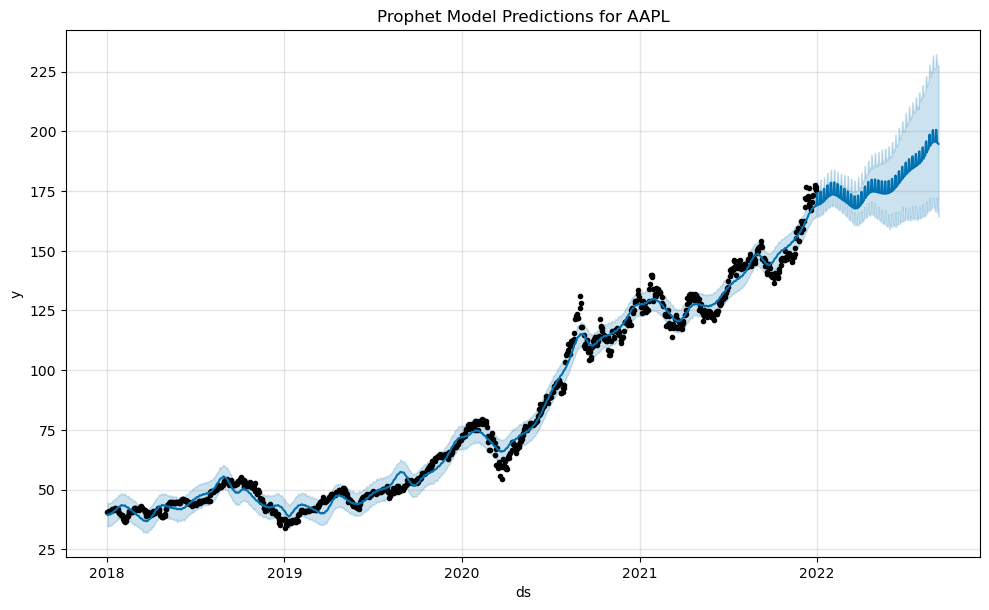

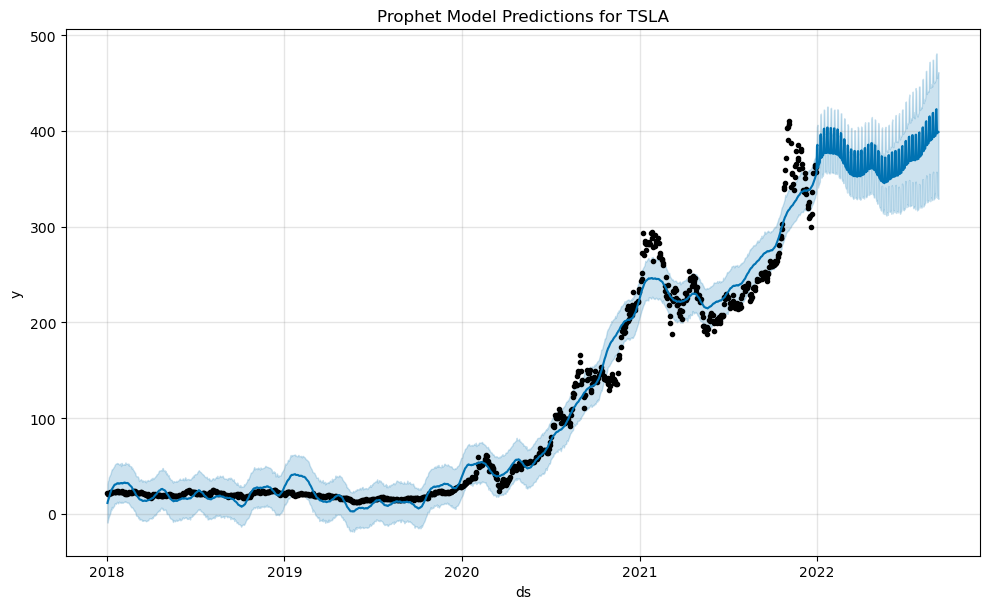

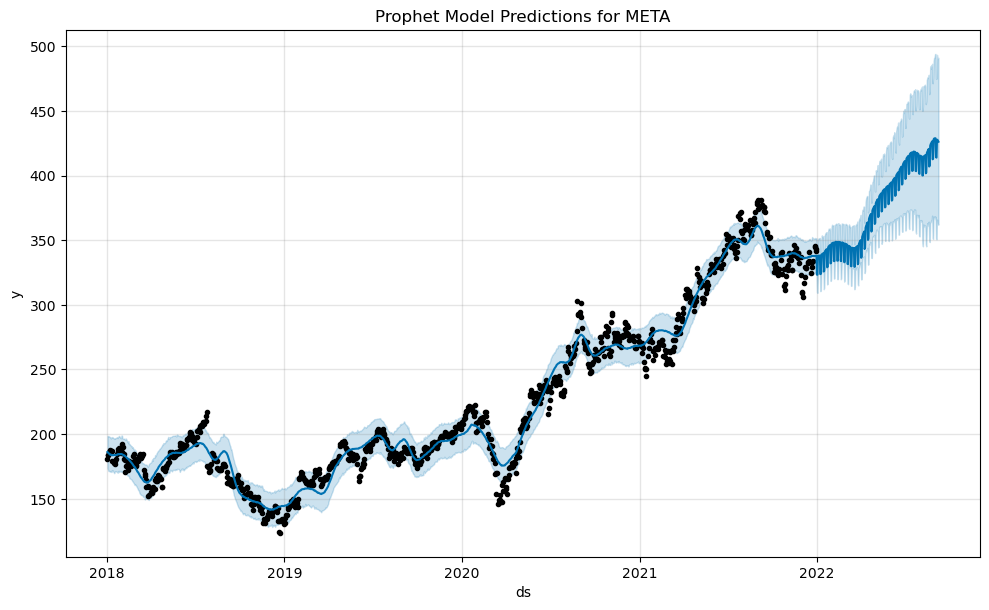

In [21]:
import os

# Create a directory for saving plots if it doesn't exist
os.makedirs("stock_forecast_plots", exist_ok=True)

# Iterate through each stock for saving predictions and plots
for stock in tickers:
    print(f"Processing stock: {stock}")
    
    # Select the stock data
    stock_series = stock_data[stock]
    
    # Train-Test Split (80-20)
    train_size = int(len(stock_series) * 0.8)
    train, test = stock_series[:train_size], stock_series[train_size:]

    # Prepare the training data for Prophet
    train_df = train.reset_index()
    train_df.columns = ['ds', 'y']
    train_df['ds'] = train_df['ds'].dt.tz_localize(None)

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Save the forecast data
    forecast_filename = f"forecast_{stock}.csv"
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(forecast_filename, index=False)
    print(f"Forecast data saved for {stock} to {forecast_filename}")

    # Save the plot
    fig = model.plot(forecast)
    plt.title(f"Prophet Model Predictions for {stock}")
    plot_filename = f"stock_forecast_plots/{stock}_forecast_plot.png"
    fig.savefig(plot_filename, dpi=300, bbox_inches="tight")
    print(f"Forecast plot saved for {stock} to {plot_filename}")

print("All forecasts and plots saved successfully.")


17:25:54 - cmdstanpy - INFO - Chain [1] start processing
17:25:54 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: AAPL
Saved plot for AAPL as forecast_plot_AAPL.png


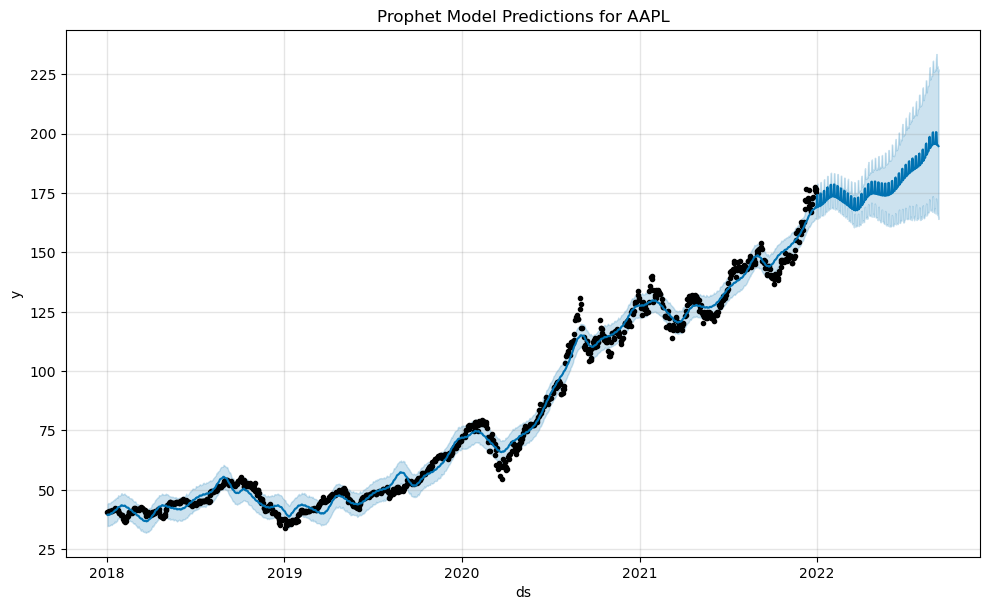

17:25:55 - cmdstanpy - INFO - Chain [1] start processing
17:25:55 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: TSLA
Saved plot for TSLA as forecast_plot_TSLA.png


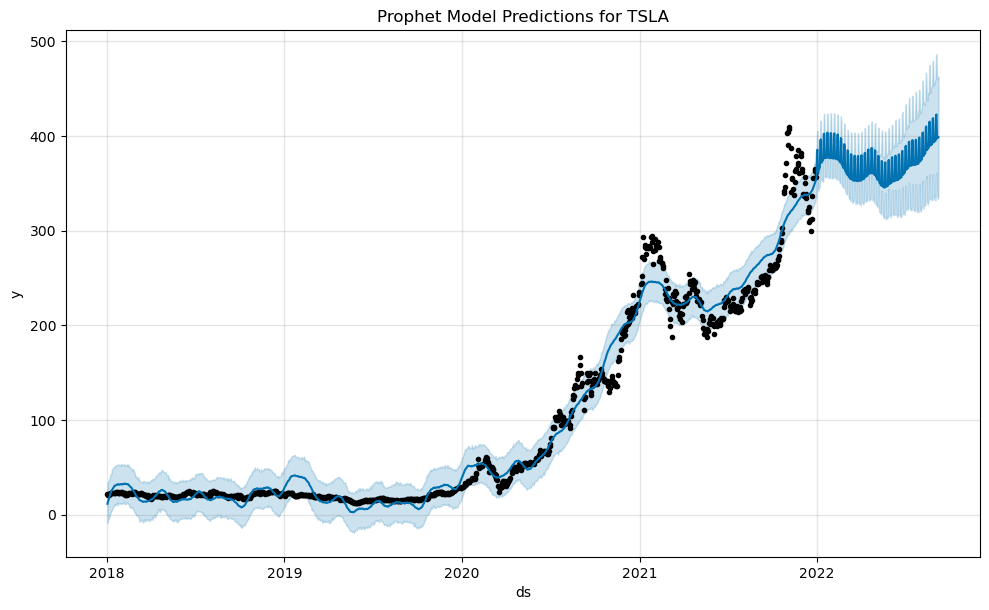

17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:25:56 - cmdstanpy - INFO - Chain [1] done processing


Processing stock: META
Saved plot for META as forecast_plot_META.png


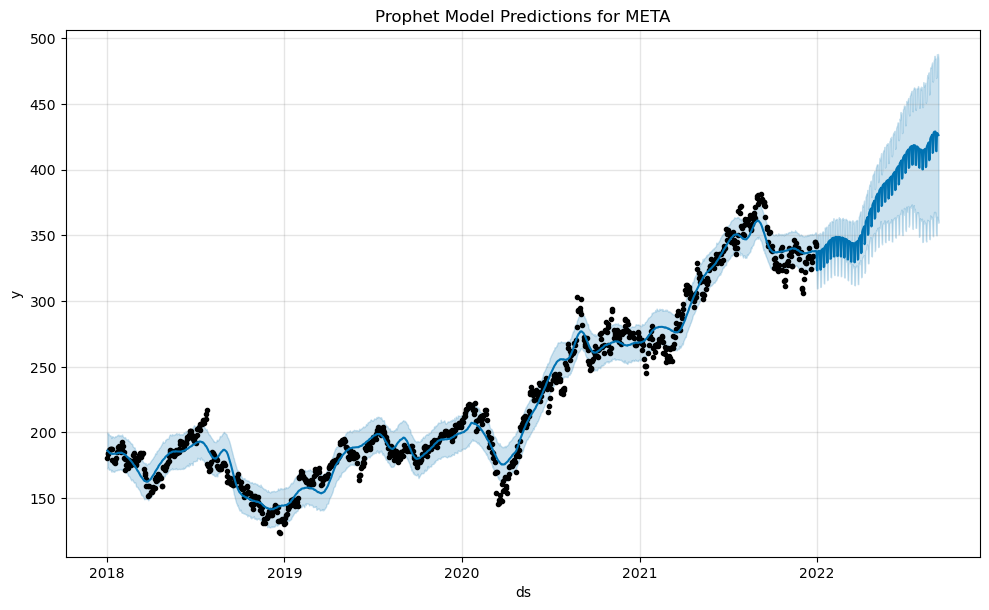

In [23]:
import matplotlib.pyplot as plt

# Iterate through each stock for analysis
for stock in tickers:
    print(f"Processing stock: {stock}")
    
    # Select the stock data
    stock_series = stock_data[stock]
    
    # Train-Test Split (80-20)
    train_size = int(len(stock_series) * 0.8)
    train, test = stock_series[:train_size], stock_series[train_size:]

    # Prepare the training data for Prophet
    train_df = train.reset_index()
    train_df.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for values
    train_df['ds'] = train_df['ds'].dt.tz_localize(None)  # Remove timezone information if present

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Create a DataFrame for future predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Plot and save the forecast
    fig = model.plot(forecast)
    plt.title(f"Prophet Model Predictions for {stock}")
    plot_filename = f"forecast_plot_{stock}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches="tight")  # Save the plot
    print(f"Saved plot for {stock} as {plot_filename}")
    plt.show()


17:26:10 - cmdstanpy - INFO - Chain [1] start processing
17:26:10 - cmdstanpy - INFO - Chain [1] done processing


Generating graph for AAPL...


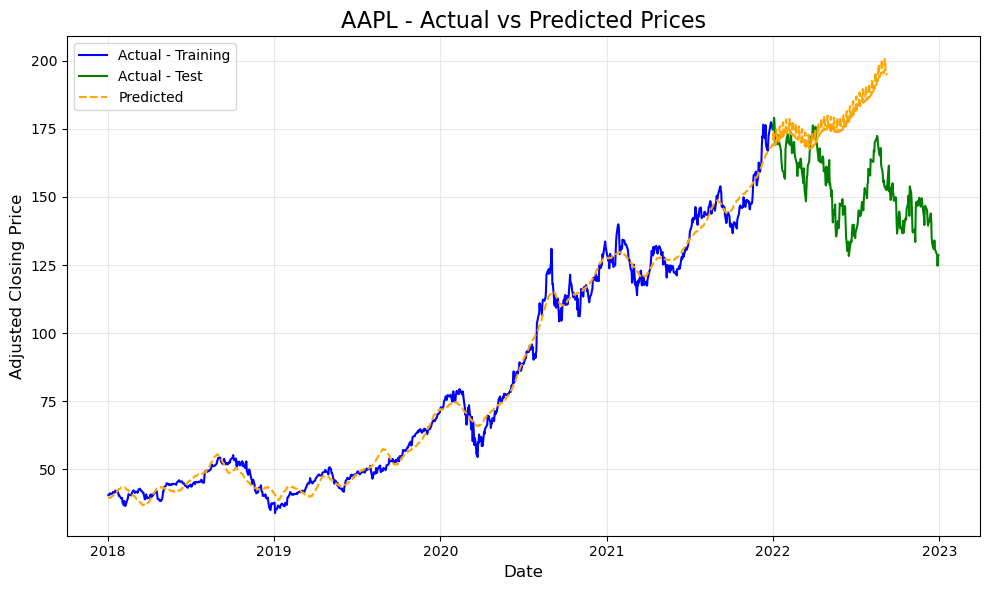

17:26:11 - cmdstanpy - INFO - Chain [1] start processing
17:26:11 - cmdstanpy - INFO - Chain [1] done processing


Graph saved as forecast_plot_AAPL.png
Generating graph for TSLA...


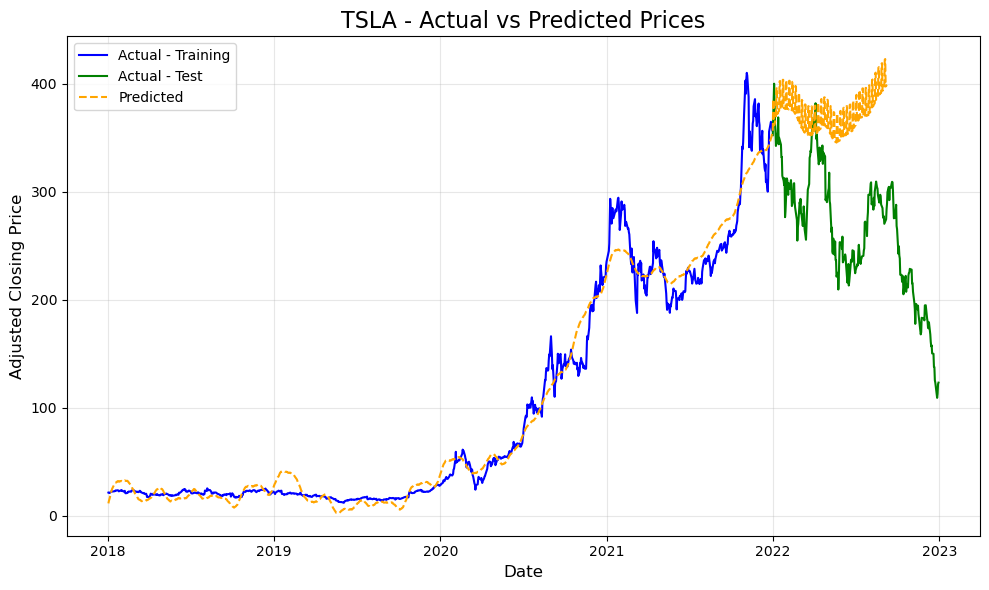

17:26:11 - cmdstanpy - INFO - Chain [1] start processing
17:26:11 - cmdstanpy - INFO - Chain [1] done processing


Graph saved as forecast_plot_TSLA.png
Generating graph for META...


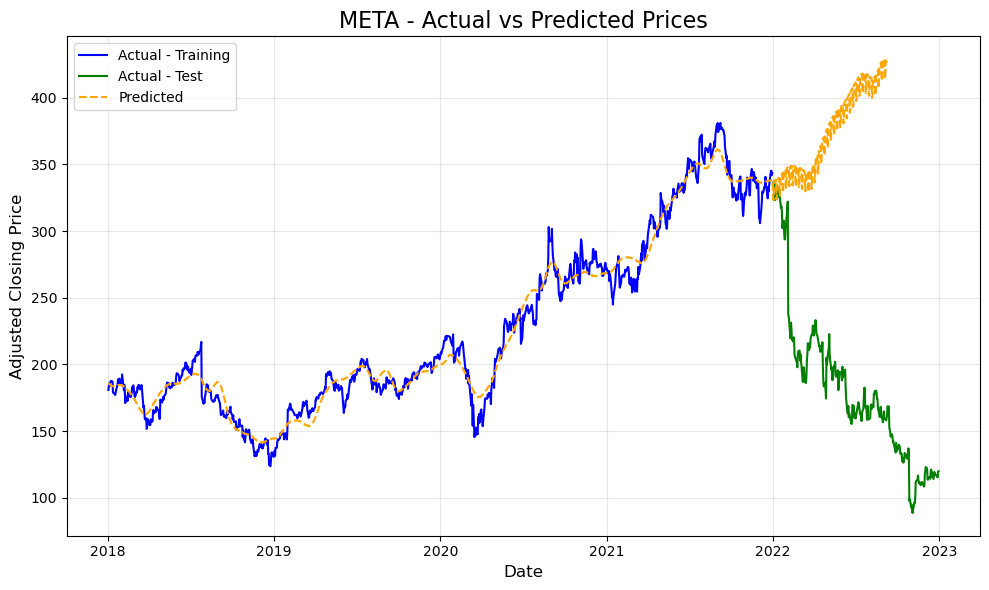

Graph saved as forecast_plot_META.png


In [25]:
import matplotlib.pyplot as plt

# Iterate through each stock to generate the graphs
for stock in tickers:
    print(f"Generating graph for {stock}...")
    
    # Select the stock's forecast and actual data
    stock_series = stock_data[stock]
    train_size = int(len(stock_series) * 0.8)
    train, test = stock_series[:train_size], stock_series[train_size:]
    
    # Prepare the forecast data
    train_df = train.reset_index()
    train_df.columns = ['ds', 'y']
    train_df['ds'] = train_df['ds'].dt.tz_localize(None)

    model = Prophet()
    model.fit(train_df)
    
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['ds'], train_df['y'], label="Actual - Training", color="blue")
    plt.plot(test.index, test.values, label="Actual - Test", color="green")
    plt.plot(forecast['ds'], forecast['yhat'], label="Predicted", color="orange", linestyle="--")
    plt.title(f"{stock} - Actual vs Predicted Prices", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Adjusted Closing Price", fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    graph_filename = f"forecast_plot_{stock}.png"
    plt.savefig(graph_filename, dpi=300)
    plt.show()
    print(f"Graph saved as {graph_filename}")

In [27]:
from fpdf import FPDF

# Initialize PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Add Title Page
pdf.add_page()
pdf.set_font("Arial", style="B", size=16)
pdf.cell(200, 10, txt="Stock Price Forecasting Report", ln=True, align="C")
pdf.ln(20)

pdf.set_font("Arial", size=12)
pdf.multi_cell(0, 10, txt=(
    "This report summarizes the results of stock price forecasting for Apple (AAPL), Tesla (TSLA), "
    "and Meta (META). The analysis includes data preprocessing, forecasting using ARIMA and Prophet models, "
    "and evaluation of predictive accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)."
))
pdf.ln(10)

# Add Section for Each Stock
metrics = {
    "AAPL": {"MAE": 27.28, "RMSE": 32.93},
    "TSLA": {"MAE": 109.59, "RMSE": 128.09},
    "META": {"MAE": 197.06, "RMSE": 214.60}
}

for stock in tickers:
    pdf.add_page()
    
    # Section Header
    pdf.set_font("Arial", style="B", size=14)
    pdf.cell(200, 10, txt=f"Forecast Results for {stock}", ln=True, align="L")
    pdf.ln(10)
    
    # Insert Graph
    forecast_image = f"forecast_plot_{stock}.png"
    try:
        pdf.image(forecast_image, x=10, y=None, w=180)
        pdf.ln(10)
    except FileNotFoundError:
        pdf.cell(0, 10, txt=f"Graph for {stock} not found.", ln=True)
    
    # Add Evaluation Metrics
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, txt=f"Evaluation Metrics for {stock}:", ln=True)
    pdf.cell(0, 10, txt=f"  - Mean Absolute Error (MAE): {metrics[stock]['MAE']:.2f}", ln=True)
    pdf.cell(0, 10, txt=f"  - Root Mean Squared Error (RMSE): {metrics[stock]['RMSE']:.2f}", ln=True)
    pdf.ln(10)

# Save the PDF
pdf.output("Stock_Price_Forecasting_Report.pdf")
print("PDF report successfully created and saved as 'Stock_Price_Forecasting_Report.pdf'")


PDF report successfully created and saved as 'Stock_Price_Forecasting_Report.pdf'


# Stock Price Forecasting with ARIMA and Prophet Models

## **Overview**
This project forecasts stock prices for Apple (AAPL), Tesla (TSLA), and Meta (META) using ARIMA and Prophet models. The goal is to analyze past performance and evaluate predictive accuracy.

## **Project Workflow**
1. **Data Collection**:
   - Stock data fetched using Yahoo Finance.
   - Missing values handled with forward-fill and back-fill techniques.

2. **Data Analysis**:
   - Historical trends visualized.
   - Moving averages and correlation matrix calculated.

3. **Forecasting**:
   - ARIMA and Prophet models used for prediction.
   - Graphs generated for actual vs. predicted prices with confidence intervals.

4. **Evaluation Metrics**:
   - Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) calculated for each stock.

5. **Reports**:
   - Individual PDF reports generated with forecasts and evaluation metrics.

## **Outputs**
- **Data Files**:
  - `stock_prices_cleaned.csv`: Cleaned stock data.
  - `stock_summary_statistics.csv`: Summary statistics.
  - `forecast_evaluation_metrics.csv`: MAE and RMSE metrics.

- **Graphs**:
  - Historical stock prices, moving averages, and predicted vs. actual prices for each stock.

- **Reports**:
  - PDF reports for each stock summarizing predictions and evaluation metrics.